# Script to explore radar picks

## Import packages

In [48]:
import geopandas as gpd
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import numpy as np
import pandas as pd
import math

# complicated plotting
import rasterio
from rasterio.plot import show
import pyproj

from geopy.distance import distance
from geopy import Point


## set basic parameters

In [49]:

# define cores

class core:
    def __init__(self, name, lat, lon, depth):
        self.name = name
        self.lat = lat
        self.lon = lon
        self.depth = depth

    def get_dist_to_track(self,lat,lon):

        self.track_dist=10000
        for i in range(len(lat)):
            d = haversine((lat[i],lon[i]),(self.lat,self.lon),unit=Unit.METERS)
            if d < self.track_dist:
                self.track_dist = d
                self.track_idx = i

ALHIC2302 = core('ALHIC2302',-76.74543,159.37513, 186.39)
ALHIC2201 = core('ALHIC2201',-76.732027,159.359551, 90)
ALHIC1902 = core('ALHIC1902',-76.745357,159.374108, 206.53)
ALHIC1901 = core('ALHIC1901',-76.732376,159.356125, 159.84)


## Calculate Weighted Percentile

In [50]:
# define function for weighted_percentile
def weighted_percentile(values, weights, percentiles):
    
    # Convert percentiles to fractions
    percentiles = [p / 100 for p in percentiles]

    # Convert values and weights to numpy arrays
    values = np.array(values)
    weights = np.array(weights)
    percentiles = np.array(percentiles)

    # Check for NaN values and remove them
    nan_mask = np.isnan(values) | np.isnan(weights)
    if np.any(nan_mask):
        print("NaN values found and will be removed.")
    values = values[~nan_mask]
    weights = weights[~nan_mask]
    
    # Sort values and weights by values
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    sorted_weights = weights[sorted_indices]
    
    # Compute the cumulative sum of weights
    cumulative_weights = np.cumsum(sorted_weights)
    
    # Normalize the cumulative weights to get the cumulative distribution
    cumulative_distribution = cumulative_weights / cumulative_weights[-1]
    
    # Interpolate to find the weighted percentiles
    weighted_percentiles = np.interp(percentiles, cumulative_distribution, sorted_values)
    
    return weighted_percentiles

# define function to calculate percentiles from dataframe with true dip angles
def calc_percentiles(df,percentiles):

    # initialize list to store dip statistics
    dip_stats = []
    # define if we are looking at AC or DC (AC is default)
    ACorDC = 'AC'

    # loop through each row in the dataframe
    for index,row in df.iterrows():

        # pull out approriate data
        dip = np.array(row[ACorDC+'-true-angles'])
        scores = np.array(row[ACorDC+'-true-scores'])
        
        # plot dip
        a = weighted_percentile(dip, scores, percentiles)
       # weighted_percentile(dip, percentiles, weights=scores, interpolation='step')
        dip_stats.append(a)

        # check
        for i in range(len(a)-1):
            if a[i]>a[i+1]:
                print('Error: Percentiles are not in order in section '+row['section'])

    df['dip_percentiles']  = dip_stats
    return df

## Basic data import and exploration

In [51]:
# Function to load the shapefile and check basic information
def load_shapefile(file_path):
    try:
        # Load the shapefile using geopandas
        gdf = gpd.read_file(file_path)
        
        # Display basic information about the data
        print("Loaded shapefile successfully!")
        print("Number of features:", len(gdf))
        print("CRS (Coordinate Reference System):", gdf.crs)
        print("First few rows of the data:")
        print(gdf.head())
        
        # Show the columns in the shapefile
        print("\nColumns in the shapefile:")
        print(gdf.columns)

        # You can access the geometry (the spatial component) and attributes here
        print("\nSample geometry:")
        print(gdf.geometry.head())

    except Exception as e:
        print(f"Error loading shapefile: {e}")

    return gdf

# Provide the path to the .shp file
#shapefile_path = "../../../radar_picks/picks-v2-culled-2melev.shp"
shapefile_path = "../../../radar_picks/picks-v2-culled.shp"
gdf = load_shapefile(shapefile_path)


Loaded shapefile successfully!
Number of features: 26422
CRS (Coordinate Reference System): EPSG:3031
First few rows of the data:
  Filename  St. Scan  End Scan      Lat()      Long() Layer 1 Na  Layer 1 Sc  \
0     None         0      6008 -76.733516  159.345061    Layer 1        1640   
1     None         0      6008 -76.733500  159.345184    Layer 1        1650   
2     None         0      6008 -76.733482  159.345314    Layer 1        1660   
3     None         0      6008 -76.733463  159.345453    Layer 1        1670   
4     None         0      6008 -76.733446  159.345595    Layer 1        1680   

   Layer 1 De  Layer 1 2-  Layer 1 La Layer 2 Na  Layer 2 Sc Layer 2 2-  \
0     296.246     3485.24        3.11    Layer 2        1640       None   
1     293.899     3457.63        3.11    Layer 2        1650       None   
2     290.823     3421.45        3.11    Layer 2        1660       None   
3     288.557     3394.79        3.11    Layer 2        1670       None   
4     285.805 

In [52]:
gpd.read_file(shapefile_path)

,Filename,St. Scan,End Scan,Lat(),Long(),Layer 1 Na,Layer 1 Sc,Layer 1 De,Layer 1 2-,Layer 1 La,Layer 2 Na,Layer 2 Sc,Layer 2 2-,Layer 2 La,geometry
0,None,0,6008,-76.733516,159.345061,Layer 1,1640,296.246,3485.24,3.11,Layer 2,1640,None,None,POINT Z (510642.750 -1354597.756 296.246)
1,None,0,6008,-76.733500,159.345184,Layer 1,1650,293.899,3457.63,3.11,Layer 2,1650,None,None,POINT Z (510640.453 -1354600.480 293.899)
2,None,0,6008,-76.733482,159.345314,Layer 1,1660,290.823,3421.45,3.11,Layer 2,1660,None,None,POINT Z (510638.085 -1354603.502 290.823)
3,None,0,6008,-76.733463,159.345453,Layer 1,1670,288.557,3394.79,3.11,Layer 2,1670,None,None,POINT Z (510635.518 -1354606.657 288.557)
4,None,0,6008,-76.733446,159.345595,Layer 1,1680,285.805,3362.42,3.11,Layer 2,1680,None,None,POINT Z (510632.811 -1354609.654 285.805)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26417,None,0,5368,-76.759408,159.343183,Layer 1,4230,290.742,3420.50,3.11,Layer 2,4230,None,None,POINT Z (509681.862 -1351914.524 290.742)
26418,None,0,5368,-76.759384,159.343187,Layer 1,4240,292.280,3438.59,3.11,Layer 2,4240,None,None,POINT Z (509682.674 -1351916.993 292.280)
26419,None,0,5368,-76.759361,159.343190,Layer 1,4250,293.737,3455.73,3.11,Layer 2,4250,None,None,POINT Z (509683.520 -1351919.438 293.737)
26420,None,0,5368,-76.759338,159.343193,Layer 1,4260,295.517,3476.67,3.11,Layer 2,4260,None,None,POINT Z (509684.351 -1351921.842 295.517)


/Users/Liam/anaconda3/envs/ecm/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/Liam/anaconda3/envs/ecm/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_16593/4169657102.py:33: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#u

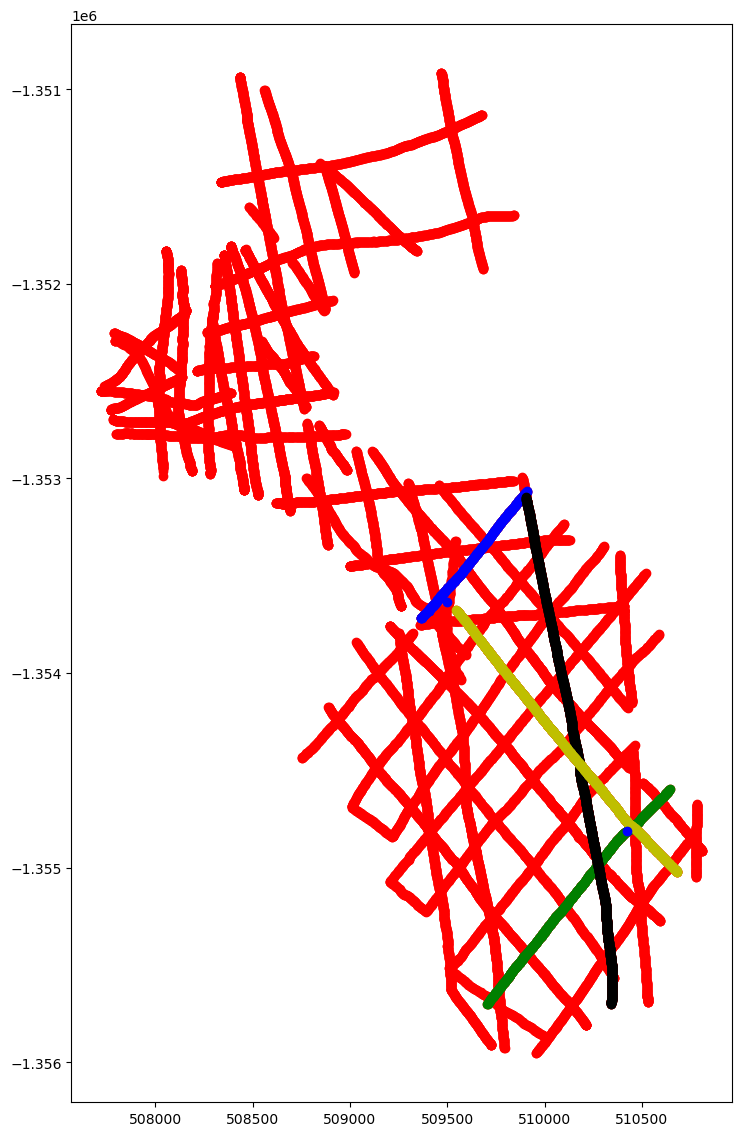

In [53]:
# tool to find the correct lines

fig,ax = plt.subplots(figsize=(14,14))

gdf.plot(ax = ax, color='r')

lo = 1510 # this is right
hi = 1750 # this is right
line23 = gdf[lo:hi]
line23.plot(ax=ax, color='b')

lo = 0 # this is right
hi = 437 # this is right
line02 = gdf[lo:hi]
line02.plot(ax=ax, color='g')

lo = 19250 # this is right but for line 31
hi = 20385 # this is right but for line 31
#lo = 10398
#hi = 11300
line33 = gdf[lo:hi]
line33.plot(ax=ax, color='k')

#lo = 8233 # this is right but for line 29
#hi = 9218 # this is right but for line 29
lo = 437
hi = 987
line03 = gdf[lo:hi]
line03.plot(ax=ax, color='y')

# add the core locations to plot (converting to plolar stereographic)
for c in [ALHIC1901,ALHIC1902]:
    x,y = pyproj.transform(pyproj.Proj(init='epsg:4326'),pyproj.Proj(init='epsg:3031'),c.lon,c.lat)
    ax.plot(x,y,'bo')
    


In [54]:
# import math

# # Get the first and last points
# calculate bering, from https://spatial-dev.guru/2024/04/06/python-tutorial-calculating-azimuth-elevation-and-slant-range-between-two-points-on-earth/
def calculate_bearing(lat1, lon1, lat2, lon2):
#     # Convert decimal degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
 
#     dlon = lon2_rad - lon1_rad
 
#     y = math.sin(dlon) * math.cos(lat2_rad)
#     x = math.cos(lat1_rad) *  math.sin(lat2_rad) - \
#         math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(dlon)
 
#     bearing_rad = math.atan2(y, x)
#     bearing_deg = math.degrees(bearing_rad)
 
#     # Normalize to [0, 360) degrees
#     bearing_deg = (bearing_deg + 360) % 360
 
#     return bearing_deg

# # Calculate the azimuth
# def calculate_azimuth(line,name):

#     start = (line.iloc[0]['Lat()'], line.iloc[0]['Long()'])
#     end = (line.iloc[-1]['Lat()'], line.iloc[-1]['Long()'])
#     lat1, lon1 = start
#     lat2, lon2 = end
#     azimuth = calculate_bearing(lat1, lon1, lat2, lon2)

#     print(f"The azimuth between the first and last point in "+name+" is "+str(round(azimuth,1))+" degrees or "+str(round((azimuth+180)%360,1))+" degrees.")
#     return azimuth

# azimuth = calculate_azimuth(line02,'Line 2')
# azimuth = calculate_azimuth(line23,'Line 23')




In [55]:
path_to_angles = '../../data/angles/'
alhic2302_angle = pd.read_csv(path_to_angles+'alhic2302_simple_dip.csv')
alhic2201_angle = pd.read_csv(path_to_angles+'alhic2201_simple_dip.csv')


 Distance between ALHIC2302 and line is  24.835536765857537
 Distance between ALHIC1902 and line is  44.851048234582464
Bed slope near ALHIC2302 is  0.6426997198964646  or  32.728843665040266 °
 Distance between ALHIC2201 and line is  1.0039180865160766
 Distance between ALHIC1901 and line is  3.1895373898790425
Bed slope near ALHIC2201 is  0.5243448911765873  or  27.67004010623935 °


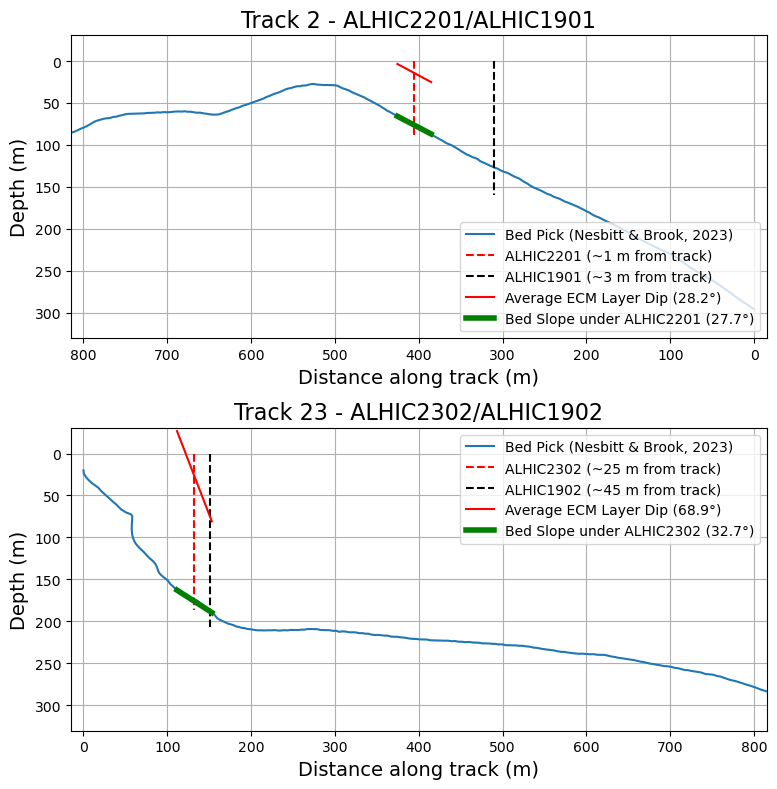

In [56]:
fig,axs = plt.subplots(2,1,figsize=(8,8))

for line,name,ax,cores,core_angle in zip([line23,line02],
                                         ['Track 23','Track 2'],
                                         [axs[1],axs[0]],
                                         [[ALHIC2302,ALHIC1902],[ALHIC2201,ALHIC1901]],
                                         [alhic2302_angle,alhic2201_angle]):
    
    # calculate the mean angle for all sections where the IQR is less than 20 degrees
    valid_angles = []
    valid_depths = []
    for idx, row in core_angle.iterrows():

        if row['IQR'] < 20:
            valid_angles.append(row['median-dip'])
            valid_depths.append(row['depth'])
    if valid_angles:
        angle_mean = np.mean(abs(np.array(valid_angles)))
        angle_depth_mean = np.mean(valid_depths)
    else:
        print("ERROR: NO VALID ANGLES")

    # Get the latitude, longitude, and depth values
    lat = line['Lat()'].to_numpy()
    lon = line['Long()'].to_numpy()
    depth = line['Layer 1 De'].to_numpy()

    # find closest point on line
    for core in cores:
        core.get_dist_to_track(lat,lon)
        print(" Distance between "+core.name+" and line is ",core.track_dist)

    # compute distance along track
    dist = []
    for la,lo in zip(lat,lon):
        dist.append(haversine((lat[0],lon[0]),(la,lo),unit=Unit.METERS))

    # plot the data
    ax.plot(dist,depth,label='Bed Pick (Nesbitt & Brook, 2023)')

    # plot core location
    color = ['r--','k--']
    for core,c in zip(cores,color):
        label = core.name + ' (~'+str(round(core.track_dist))+' m from track)'
        ax.plot([dist[core.track_idx],dist[core.track_idx]],[0,core.depth],c,label=label)

    # calculate the bed slope near the core
    core = cores[0] # pick relevant core
    idx = core.track_idx
    dist_min = dist[idx] - 20
    dist_max = dist[idx] + 20
    idx_min = int(round(np.interp(dist_min,dist,range(len(dist)))))
    idx_max = int(round(np.interp(dist_max,dist,range(len(dist)))))
    slope = abs((depth[idx_max] - depth[idx_min])/(dist[idx_max] - dist[idx_min]))
    dip = np.arctan(slope)*180/np.pi
    print('Bed slope near '+core.name+' is ',slope,' or ',dip,'°')

    # Plot ECM angle
    hor = (dist[idx_max] - dist[idx_min])/2
    if name == 'Track 23':
        mult = 1
    else:
        mult = -1
    offset = hor * np.tan(angle_mean*np.pi/180)
    ax.plot([dist[idx_min],dist[idx_max]],
            [angle_depth_mean-offset*mult,angle_depth_mean+offset*mult],
            'r',
            label = 'Average ECM Layer Dip ('+str(round(angle_mean,1))+'°)')


    # plot the bed slope
    ax.plot([dist[idx_min],dist[idx_max]],[depth[idx_min],depth[idx_max]],
            'g',
            label='Bed Slope under '+core.name+' ('+str(round(dip,1))+'°)',
            linewidth=4)

    # set axis to equal scale
    ax.axis('equal')

    # apply x axis limits
    if name == 'Track 23':
        ax.set_xlim(0,800)
        ax.legend(loc='upper right')
    else:
        ax.set_xlim(800,0)
        ax.legend(loc='lower right')


    # plot housekeeping
    title = name + ' - ' + cores[0].name +'/'+cores[1].name 
    ax.set_title(title,fontsize=16)
    ax.set_xlabel('Distance along track (m)', fontsize=14)
    ax.set_ylabel('Depth (m)', fontsize=14)
    ax.set_ylim(300,0)
    ax.grid(True)

fig.tight_layout()

fig.savefig('../../../figures/paper_figures/radar.png')

ax_save = axs[1]

In [57]:
# set up for this plot - make transformer

# Define the EPSG code for the Antarctic Polar Stereographic projection
epsg_code = 'epsg:3031'

# Create a transformer object
transformer = pyproj.Transformer.from_crs('epsg:4326', epsg_code)


 Distance between ALHIC2302 and line is  24.835536765857537
Bed slope near ALHIC2302 is  0.6426997198964646  or  32.728843665040266 °
 Distance between ALHIC2201 and line is  1.0039180865160766
Bed slope near ALHIC2201 is  0.5243448911765873  or  27.67004010623935 °


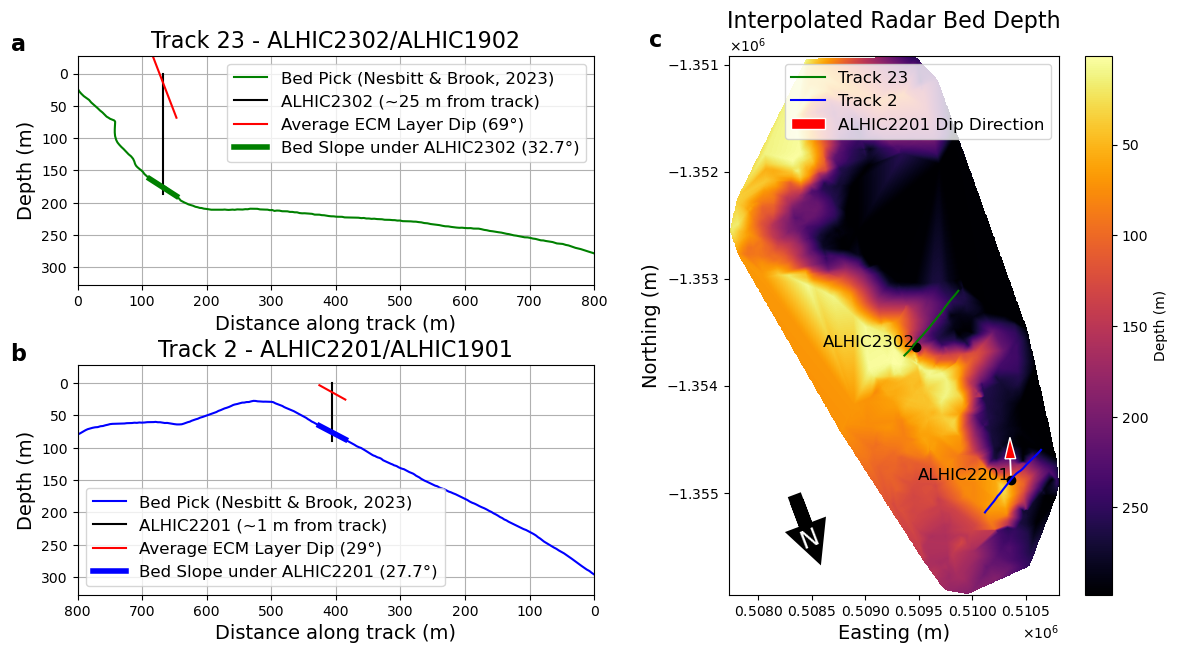

In [ ]:
# Make a figure

fig = plt.figure(figsize=(14,7))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 3], height_ratios=[1, 1], wspace=0.1, hspace=0.35)

# Create the two wide but short subplots on the left
ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax2 = fig.add_subplot(gs[1, 0])  # Bottom-left

# Create the tall, narrow subplot on the right
ax3 = fig.add_subplot(gs[:, 1])  # Right side, spanning both rows

###############################################################################################################
# TOP AND  BOTTOM SUBPLOT

# save index of what shows up on plot
idx_lo = []
idx_hi = []

for line,name,ax,cores,angle_mean,linestyle in zip([line23,line02],
                                         ['Track 23','Track 2'],
                                         [ax1,ax2],
                                         [[ALHIC2302,ALHIC1902],[ALHIC2201,ALHIC1901]],
                                         [69,29],
                                         ['g-','b-']):
    

    # Get the latitude, longitude, and depth values
    lat = line['Lat()'].to_numpy()
    lon = line['Long()'].to_numpy()
    depth = line['Layer 1 De'].to_numpy()

    # find closest point on line
    for core in cores:
        if core.name != 'ALHIC1902' and core.name != 'ALHIC1901':
            core.get_dist_to_track(lat,lon)
            print(" Distance between "+core.name+" and line is ",core.track_dist)

    # compute distance along track
    dist = []
    for la,lo in zip(lat,lon):
        dist.append(haversine((lat[0],lon[0]),(la,lo),unit=Unit.METERS))

    # plot the data
    ax.plot(dist,depth,linestyle,label='Bed Pick (Nesbitt & Brook, 2023)')

    # plot core location
    color = ['k-','k-']
    for core,c in zip(cores,color):
        if core.name != 'ALHIC1902' and core.name != 'ALHIC1901':
            label = core.name + ' (~'+str(round(core.track_dist))+' m from track)'
            ax.plot([dist[core.track_idx],dist[core.track_idx]],[0,core.depth],c,label=label)

    # calculate the bed slope near the core
    core = cores[0] # pick relevant core
    idx = core.track_idx
    dist_min = dist[idx] - 20
    dist_max = dist[idx] + 20
    idx_min = int(round(np.interp(dist_min,dist,range(len(dist)))))
    idx_max = int(round(np.interp(dist_max,dist,range(len(dist)))))
    slope = abs((depth[idx_max] - depth[idx_min])/(dist[idx_max] - dist[idx_min]))
    dip = np.arctan(slope)*180/np.pi
    print('Bed slope near '+core.name+' is ',slope,' or ',dip,'°')

    # Plot ECM angle
    hor = (dist[idx_max] - dist[idx_min])/2
    if name == 'Track 23':
        mult = 1
    else:
        mult = -1
    offset = hor * np.tan(angle_mean*np.pi/180)
    ax.plot([dist[idx_min],dist[idx_max]],
            [angle_depth_mean-offset*mult,angle_depth_mean+offset*mult],
            'r',
            label = 'Average ECM Layer Dip ('+str(round(angle_mean))+'°)')


    # plot the bed slope
    ax.plot([dist[idx_min],dist[idx_max]],[depth[idx_min],depth[idx_max]],
            linestyle,
            label='Bed Slope under '+core.name+' ('+str(round(dip,1))+'°)',
            linewidth=4)

    # set axis to equal scale
    ax.axis('equal')

    # apply x axis limits
    if name == 'Track 23':
        ax.set_xlim(0,800)
        ax.legend(loc='upper right', fontsize=12)
    else:
        ax.set_xlim(800,0)
        ax.legend(loc='lower left', fontsize=12)

    idx_lo.append(dist.index(min(filter(lambda d: d > 0, dist))))
    idx_hi.append(dist.index(max(filter(lambda d: d < 800, dist))))

    # plot housekeeping
    title = name + ' - ' + cores[0].name +'/'+cores[1].name 
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Distance along track (m)', fontsize=14)
    ax.set_ylabel('Depth (m)', fontsize=14)
    ax.set_ylim(300,0)
    ax.grid(True)

#fig.tight_layout()

#fig.savefig('../../../figures/paper_figures/radar.png')


################################################################################################################
# RIGHT SUBPLOT

# Open the file using rasterio
with rasterio.open('../../../radar_picks/test.tif') as src:
    # Plot the GeoTIFF
    show(src, ax=ax3, cmap='inferno_r')
    
    # Add colorbar
    cbar = plt.colorbar(ax3.images[0], ax=ax3, orientation='vertical')
    cbar.set_label('Depth (m)')
    cbar.ax.invert_yaxis()

#%% add info to the right subplot
for core in [ALHIC2302,ALHIC2201]:

    x,y = transformer.transform(core.lat,core.lon)

    ax3.plot(x, y, 'ko')
    ax3.text(x-10, y, core.name, fontsize=12, ha = 'right')


cnt = 0
for line,linestyle,track_name in zip([line23,line02],['g-','b-'],['Track 23','Track 2']):
    
    lat = line['Lat()'].to_numpy()
    lon = line['Long()'].to_numpy()
    x,y = transformer.transform(lat,lon)

    ax3.plot(x[idx_lo[cnt]:idx_hi[cnt]], y[idx_lo[cnt]:idx_hi[cnt]], linestyle,label=track_name)

    cnt+=1


# Add title and labels
ax3.set_title('Interpolated Radar Bed Depth', fontsize=16)
ax3.set_xlabel('Easting (m)', fontsize=14)
ax3.set_ylabel('Northing (m)', fontsize=14)

#%% do the arrow for Dip Direction

# Define the distance and heading
d = 0.2 # distance in kilometers
h = 199.5  # heading in degrees (0 is north, 90 is east, etc.)

# Create a Point object for the starting location
start_point = Point(ALHIC2201.lat, ALHIC2201.lon)

# Use geopy's distance and heading to calculate the destination
destination = distance(kilometers=d).destination(start_point, h)

x1,y1 = transformer.transform(ALHIC2201.lat,ALHIC2201.lon)
x2,y2 = transformer.transform(destination.latitude,destination.longitude)

ax3.arrow(x1, y1, x2-x1, y2-y1, head_width=100, head_length=200, fc='r', ec='w', label='ALHIC2201 Dip Direction')

#%% do the arrow for True North
d = 0.3 # distance in kilometers
h = 0  # heading in degrees (0 is north, 90 is east, etc.)
h_offset = -200
v_offset = -2000
start_point = Point(ALHIC2201.lat, ALHIC2201.lon)
destination = distance(kilometers=d).destination(start_point, h)
x1,y1 = transformer.transform(ALHIC2201.lat,ALHIC2201.lon)
x2,y2 = transformer.transform(destination.latitude,destination.longitude)
ax3.arrow(x1+v_offset, y1+h_offset, x2-x1, y2-y1, head_width=200, head_length=200, fc='k', ec='k', linewidth=10)

# add a white "N" inside the north arrow above
th_offset = -355
tv_offset = 125
ax3.text(x1+v_offset+tv_offset, y1+h_offset+th_offset, 'N', fontsize=18, ha='center', va='center', color='w', rotation=21)

# Add labels a), b), and c) to the subplots
ax1.text(-0.1, 1.1, 'a', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(-0.1, 1.1, 'b', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax3.text(-0.2, 1.05, 'c', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Add a legend
ax3.legend(fontsize=12)

from matplotlib.ticker import ScalarFormatter

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((6,6))  # Forces scientific notation for values ~1e6

ax3.xaxis.set_major_formatter(formatter)
ax3.ticklabel_format(axis='x', style='sci')  # optional fallback
ax3.yaxis.set_major_formatter(formatter)
ax3.ticklabel_format(axis='y', style='sci')  # optional fallback

# save the figure
fig.savefig('../../../figures/paper_figures/radar.png')


# save the figure (final version)
path_to_final_fig = '../../../final_submission_try2/'
fig.savefig(path_to_final_fig+'JOG-2024-0148.Figure11.pdf')
fig.savefig(path_to_final_fig+'JOG-2024-0148.Figure11.eps')
fig.savefig(path_to_final_fig+'png/'+'JOG-2024-0148.Figure11.png', dpi=170)